# (Try to) identify signals of gentrification from Airbnb data

In [74]:
import os
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from scipy.stats import zscore, gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.colors as colors
from datetime import datetime
import seaborn as sns
from shapely.geometry import Point
from geopandas import GeoDataFrame
from IPython.core.pylabtools import figsize
from fontTools.varLib.interpolatableHelpers import matching_for_vectors
import folium
import branca.colormap as cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from PlottingFunctions import *

cmap = plt.get_cmap('plasma', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

In [75]:
city='manchester'

### Get just Manchester LSOAs

In [76]:
lsoas =  gpd.read_file('../../data/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
pattern = '|'.join(manc_lads)
manchester_lsoas =lsoas[lsoas['LSOA11NMW'].str.contains(pattern)]

## Get gentrification scores

In [77]:
base_dir = os.path.expanduser(f"../../data/airbnb-{city}/")
gentrication_cat_df = pd.read_csv(base_dir + 'airbnb_gentrification_scores_categorical_combined_listings_02.csv')
mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
gentrication_cat_df['gentrification_prediction_code'] = gentrication_cat_df['gentrification_prediction'].map(mapping)

In [78]:
# Convert to geodtaframe
gentrication_cat_df['geometry'] = gentrication_cat_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
overall_gdf = gpd.GeoDataFrame(gentrication_cat_df, geometry='geometry', crs="EPSG:4326")
overall_gdf = overall_gdf.to_crs(manchester_lsoas.crs)
# Join to LSOA info
overall_gdf = gpd.sjoin(overall_gdf, manchester_lsoas[['LSOA11NM', 'geometry']], how='left', predicate='within')

In [79]:
# Find the most common score in each LSOA
lsoa_scores_gentrification = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].agg(lambda x: pd.Series.mode(x).iloc[0])
count = overall_gdf.groupby("LSOA11NM")["gentrification_prediction_code"].count()
count.name = 'Count'

manchester_lsoas = manchester_lsoas.sort_values(by='LSOA11NM')
manchester_lsoas = manchester_lsoas.merge(lsoa_scores_gentrification, on='LSOA11NM', how='left')
manchester_lsoas = manchester_lsoas.merge(count, on='LSOA11NM', how='left')

## Rose plots

In [80]:
manc_lads_pattern = '|'.join(manc_lads)
indicators = pd.read_csv("../../data/SocioEconomicData/Eng_imputedV3.csv")
indicators_manchester = indicators[indicators['LA_NAME'].str.contains(manc_lads_pattern)].copy()
indicators_manchester = indicators_manchester.rename(columns={"LSOA": 'LSOA11CD'})
indicators_manchester = indicators_manchester.merge(manchester_lsoas[['LSOA11CD', 'gentrification_prediction_code']], on='LSOA11CD', how='left')
indicators_manchester.sort_values(by='gentrification_prediction_code', inplace=True)
del indicators_manchester['Churn_2020']

## Rescale values between 0 and 1

In [158]:
# fig, axs=plt.subplots(ncols=2)
# axs[0].hist(indicators_manchester['Churn_2008_Z'])
# axs[1].hist(indicators_manchester['Churn_2008'])

### Create Rose plot

In [13]:
# 1. Identify numeric columns
numeric_cols = indicators_manchester.columns
numeric_cols = numeric_cols.drop(['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code'])

# 2. Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
scaled_minmax = minmax_scaler.fit_transform(indicators_manchester[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_minmax_df = pd.DataFrame(scaled_minmax, columns=numeric_cols)
indicators_manchester_minmax = pd.concat([indicators_manchester[['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']], scaled_minmax_df], axis=1)

# 3. Apply StandardScaler
standard_scaler = StandardScaler()
scaled_standard = standard_scaler.fit_transform(indicators_manchester[numeric_cols])

# Convert scaled values back to DataFrame and concatenate with original non-numeric columns
scaled_standard_df = pd.DataFrame(scaled_standard, columns=numeric_cols)
indicators_manchester_standard = pd.concat([indicators_manchester[['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']], scaled_standard_df], axis=1)

In [256]:
numeric_cols_Z = numeric_cols + "_Z"

In [387]:
def plot_mean_rose_with_group_labels(ax, indicators, color, all_vars):

    groups = {'Churn': [col for col in all_vars if 'Churn' in col], 'NINO': [col for col in all_vars if 'NINO' in col],
             'JSA': [col for col in all_vars if 'JSA' in col], 
              'HP': [col for col in all_vars if 'HP' in col],
              'PROF2POP': [col for col in all_vars if 'PROF2POP' in col]}
        
    # Example: Calculate means and std_devs (replace with your method)
    means = indicators[all_vars].mean().values.tolist()
    std_devs = indicators[all_vars].std().values.tolist()
    
    # Close loop for radar chart
    means += means[:1]
    std_devs += std_devs[:1]
    
    # Angles
    num_vars = len(all_vars)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Plotting means + gradient fills (your existing method)
    std_upper = np.array(means) + np.array(std_devs)
    std_lower = np.array(means) - np.array(std_devs)

    # Plot mean line
    ax.plot(angles, means, color='black', linewidth=2, label='Mean')

    # Simulate gradient by plotting multiple thin bands
    n_steps = 10  # Number of gradient layers
    for i in range(n_steps):
        alpha = 0.3 * (1 - i / n_steps)  # Fading alpha for gradient
        lower = std_lower + (means - std_lower) * (i / n_steps)
        upper = std_upper - (std_upper - means) * (i / n_steps)

        # Fill between lower and upper bands
        ax.fill_between(angles, lower, upper, color=color, alpha=alpha)

    # Set variable labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(all_vars)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

    # Title
    ax.set_title('Radar Chart with Gradient SD Range', size=14)

    # Find group labels and separators
    group_labels = {}
    separators = []
    current_idx = 0
    for group_name, group_vars in groups.items():
        count = len(group_vars)
        group_indices = list(range(current_idx, current_idx + count))
        group_angles = [angles[i] for i in group_indices]
        middle_angle = np.mean(group_angles)
        group_labels[group_name] = middle_angle
        end_idx = current_idx + count
        if end_idx < num_vars:
            separators.append(angles[end_idx])
        current_idx = end_idx

    # Add separators
    max_value = max(np.array(means) + np.array(std_devs)) * 1.1  # or a fixed value
    for sep in separators:
        ax.plot([sep, sep], [0, max_value], color='black', linewidth=2.5, linestyle='--')

    # Add group labels
    #for group_name, angle in group_labels.items():
    #    ax.text(angle, max_value * 1.15, group_name, ha='center', va='center', fontsize=12, fontweight='bold', rotation=np.rad2deg(angle), rotation_mode='anchor')

In [335]:
numeric_cols = ['Churn_2011','Churn_2012','Churn_2013','Churn_2014', 'Churn_2015','Churn_2016','Churn_2017','Churn_2018', 'Churn_2019', ]

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/integrate/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/integrate/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/integrate/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/integrate/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, "'All': \n 1673 LSOAs")

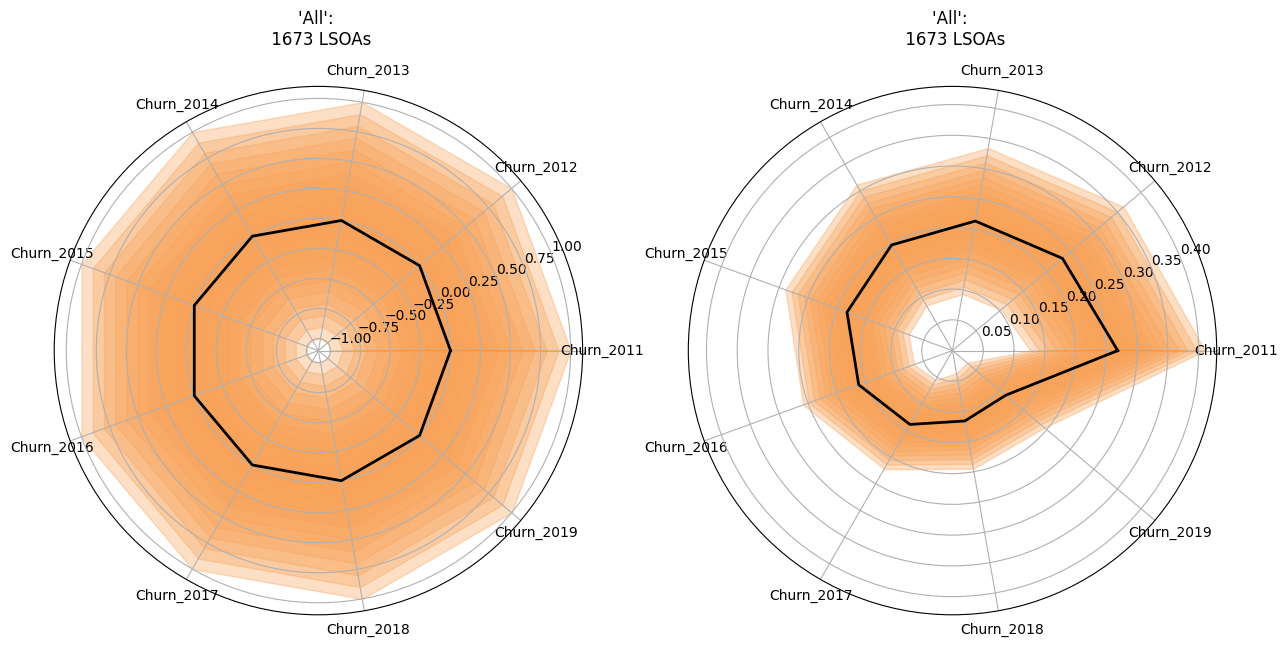

In [336]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'}, ncols=2, nrows=1, figsize=(15,10), sharex=True, sharey=False)

gentr_class = 3
key = 'All'
class_data = indicators_manchester_standard[indicators_manchester_standard['gentrification_prediction_code'] == gentr_class]
plot_mean_rose_with_group_labels(axs[0], indicators_manchester_standard, plot_colors[gentr_class],numeric_cols)
axs[0].set_title(f"'{key}': \n {len(indicators_manchester_standard)} LSOAs", size=12, pad=30)

class_data = indicators_manchester_minmax[indicators_manchester_minmax['gentrification_prediction_code'] == gentr_class]
plot_mean_rose_with_group_labels(axs[1], indicators_manchester_minmax, plot_colors[gentr_class],numeric_cols)
axs[1].set_title(f"'{key}': \n {len(indicators_manchester_minmax)} LSOAs", size=12, pad=30)

## Plot just the mean value for each

In [406]:
# # Compute means and standard deviations for each area
# means_area1 = area1.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).mean()
# means_area2 = area2.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).mean()

# stds_area1 = area1.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).std()
# stds_area2 = area2.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).std()

# # Convert to DataFrame for easier plotting
# comparison_df = pd.DataFrame({
#     "Mean_Area1": means_area1,
#     "Mean_Area2": means_area2,
#     "Std_Area1": stds_area1,
#     "Std_Area2": stds_area2
# }).reset_index().rename(columns={"index": "Variable"})

# # Compute absolute difference in means and variances
# comparison_df["Mean_Diff"] = abs(comparison_df["Mean_Area1"] - comparison_df["Mean_Area2"])
# comparison_df["Std_Diff"] = abs(comparison_df["Std_Area1"] - comparison_df["Std_Area2"])


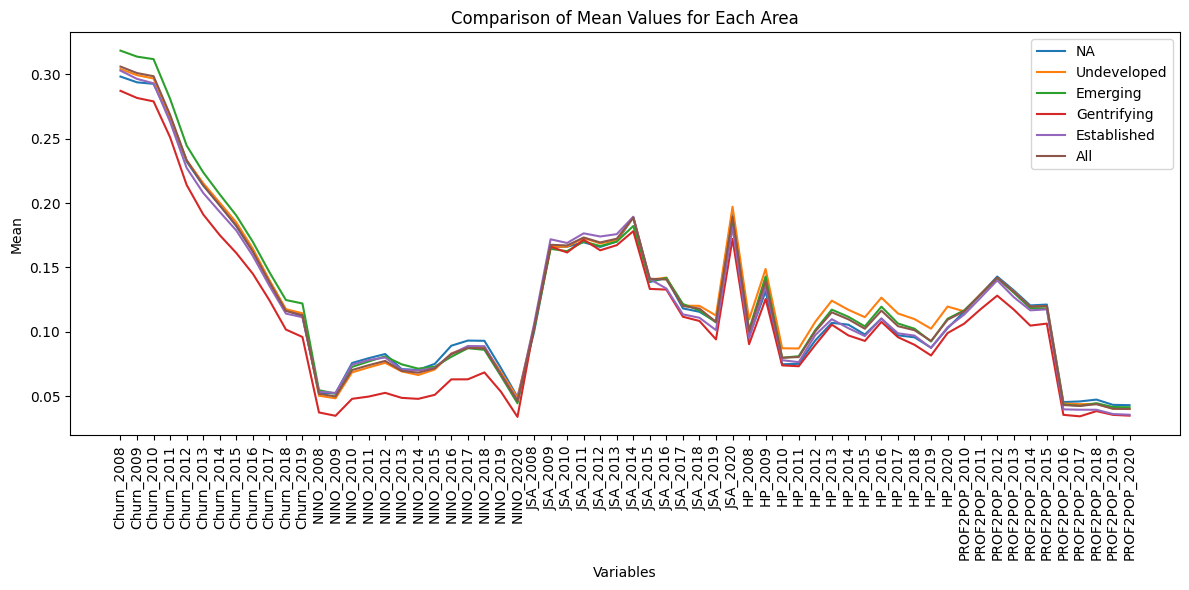

In [51]:
# Compute mean and std for all areas (same as your previous code)
areas = {
    "NA": indicators_manchester_minmax[indicators_manchester_minmax['gentrification_prediction_code'] == 0],
    "Undeveloped": indicators_manchester_minmax[indicators_manchester_minmax['gentrification_prediction_code'] == 1],
    "Emerging": indicators_manchester_minmax[indicators_manchester_minmax['gentrification_prediction_code'] == 2],
    "Gentrifying": indicators_manchester_minmax[indicators_manchester_minmax['gentrification_prediction_code'] == 3],
    "Established": indicators_manchester_minmax[indicators_manchester_minmax['gentrification_prediction_code'] == 4],
    'All': indicators_manchester_minmax
}

# Compute mean and std for all areas
stats = {}
for area, df in areas.items():
    stats[area] = {
        "Mean": df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).mean(),
        "Std": df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).std(),
        'len': len(df)
    }

# Plot means for all areas
plt.figure(figsize=(12, 6))

for area, stat in stats.items():
    plt.plot(stat["Mean"], label=area)

# Rotate x-axis labels and adjust the layout
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Variables')
plt.ylabel('Mean')
plt.title('Comparison of Mean Values for Each Area')

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.barplot(data=comparison_df.melt(id_vars="Variable", value_vars=["Mean_Area1", "Mean_Area2"]),
            x="Variable", y="value", hue="variable")
plt.xticks(rotation=90)
plt.title("Comparison of Means Between Two Areas")
plt.ylabel("Mean Value")
plt.xlabel("Variable")
plt.show()


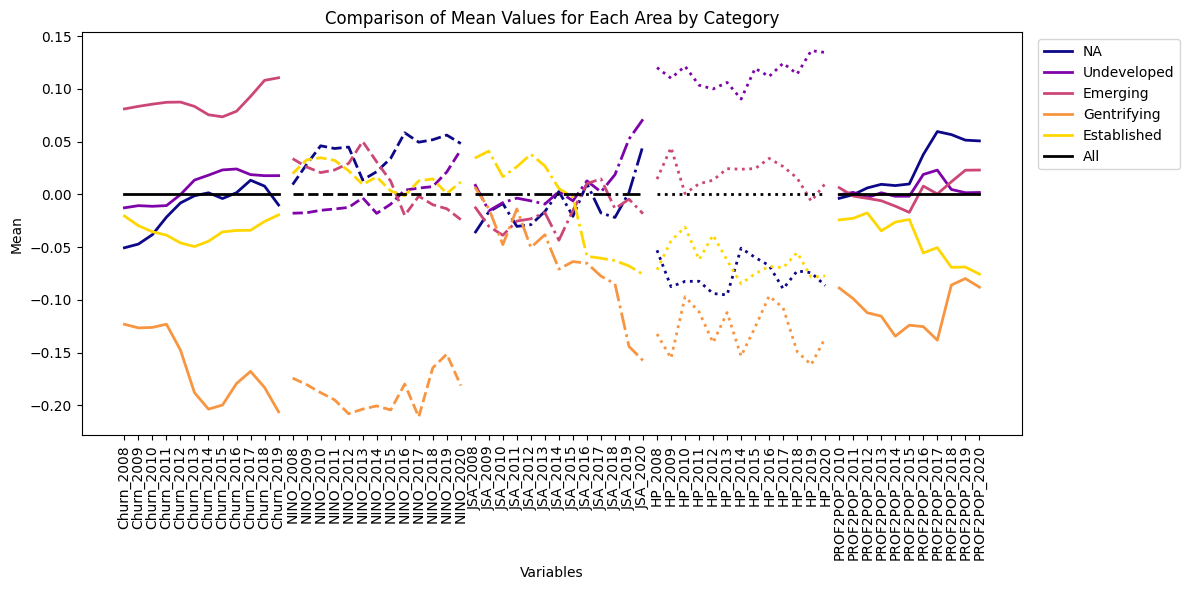

In [68]:
from matplotlib.lines import Line2D

# Define variable categories (based on column names or your own grouping logic)
variable_categories = {
    'Churn': [col for col in indicators_manchester_standard.columns if 'Churn' in col],
    'NINO': [col for col in indicators_manchester_standard.columns if 'NINO' in col],
    'JSA': [col for col in indicators_manchester_standard.columns if 'JSA' in col],
    'HP': [col for col in indicators_manchester_standard.columns if 'HP' in col],
    'PROF2POP': [col for col in indicators_manchester_standard.columns if 'PROF2POP' in col]
}

# Compute mean and std for all areas
areas = { "NA": indicators_manchester_standard[indicators_manchester_standard['gentrification_prediction_code'] == 0],
    "Undeveloped": indicators_manchester_standard[indicators_manchester_standard['gentrification_prediction_code'] == 1],
    "Emerging": indicators_manchester_standard[indicators_manchester_standard['gentrification_prediction_code'] == 2],
    "Gentrifying": indicators_manchester_standard[indicators_manchester_standard['gentrification_prediction_code'] == 3],
    "Established": indicators_manchester_standard[indicators_manchester_standard['gentrification_prediction_code'] == 4],
    'All': indicators_manchester_standard}

# Compute mean and std for all areas
stats = {}
for area, df in areas.items():
    stats[area] = {
        "Mean": df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).mean(),
        "Std": df.drop(columns=['LSOA11CD', 'LA_NAME', 'gentrification_prediction_code']).std(),
        'len': len(df)}

# Plot means for all areas, with grouping by categories
plt.figure(figsize=(12, 6))

# Different line styles for categories
category_styles = {'Churn': '-', 'NINO': '--', 'JSA': '-.', 'HP': ':', 'PROF2POP': '-'}

# Different colors for areas
area_colors = {"NA": plot_colors[0],"Undeveloped": plot_colors[1],"Emerging": plot_colors[2],"Gentrifying": plot_colors[3],"Established": plot_colors[4],'All': 'k' }

# Plot lines for each area with different categories
for area, stat in stats.items():
    # Plot each category separately
    for category, variables in variable_categories.items():
        # Extract mean values for this category
        category_mean = stat["Mean"][variables]
        
        # Plot with the corresponding color for the area and linestyle for the category
        plt.plot(category_mean, label=f'{area} - {category}', 
                 color=area_colors[area], linestyle=category_styles[category], linewidth=2)

# Rotate x-axis labels and adjust the layout
plt.xticks(rotation=90)
custom_legend = [Line2D([0], [0], color=area_colors[area], lw=2, label=area) for area in areas]

# Add the custom legend to the plot
plt.legend(handles=custom_legend, bbox_to_anchor=(1.01, 1), loc='upper left')

plt.xlabel('Variables')
plt.ylabel('Mean')
plt.title('Comparison of Mean Values for Each Area by Category')

plt.tight_layout()
plt.show()
